In [2]:
import json
import os
import pandas as pd
import numpy as np
from pathlib import Path
import collections
from sklearn.model_selection import train_test_split
from sklearn import metrics

import sys
sys.path.append("../")
from datatools.analyzer import *
from utterance.error_tools import *

from datatools.maneger import DataManager
from datatools.preproc import Preprocessor

In [3]:
class Vocabulary:
    def __init__(self, TOKENS=["[PAD]", "FOS", "EOS", "[SEP]", "[UNK]", "[NONE]"]):
        self.index2item = []
        self.item2index = {}

        for sp_token in TOKENS:
            self.add_item(sp_token)

    # 単語数
    def __len__(self):
        return len(self.item2index)

    # 単語が含まれているか
    def __contains__(self, item):
        return item in self.item2index.keys()
    
    def __str__(self) -> str:
        return str(self.item2index)

    # 単語の追加
    def add_item(self, item):
        # もう登録されてたら登録しないよ
        if item in self.item2index:
            return
        index = len(self.item2index)
        self.index2item.append(item)
        self.item2index[item] = index
    
    def add_items(self, items:list):
        for item in items:
            self.add_item(item)

    # 単語の取得
    def get_item(self, index):
        if len(self.index2item) <= index:
            return "[UNK]"
        return self.index2item[index]

    # 単語をidへ
    def get_index(self, item):
        if item not in self.item2index:
            return self.item2index["[UNK]"]
        return self.item2index[item]

    # def save_vocab(self, )

In [4]:
def load_utt_ntt():
    ntt_path = "../../corpus/NTT/"
    utt_list = []
    for file_ in os.listdir(ntt_path):
        if not "json" in file_:
            continue 
        with open(ntt_path+file_, "r",  encoding="utf-8") as f:
            convs = json.load(f)
            for did in convs["convs"]:
                dids = list( did.keys() )[0]
                conv = did[dids]
                # conv = did[dids][3::3]
                utt_list.extend( [ utt for utt in conv])
    
    print(len(utt_list))
    return utt_list

In [5]:
ntt_utt_ = load_utt_ntt()


141777


In [6]:
c_path = "../X_y_data/corpus/"
c_name = "ntt_sentence_docs.pickle"
corpusM = DataManager(c_path)

if os.path.exists(c_path+c_name):
    docs = corpusM.load_data(c_name)
    ntt_utt = list(map(str, docs))
else:
    docs = sentence2docs(ntt_utt_)
    ntt_utt = list(map(str, docs))
    corpusM.save_data(c_name, docs)

success load : ../X_y_data/corpus/ntt_sentence_docs.pickle


In [7]:
def clean_text_plain(text):
    text_ = neologdn.normalize(text)
    text_ = re.sub(r'\(.*\)', "", text_)
    text_ = re.sub(r'\d+', "0", text_)
    return text_

In [8]:
def read_file(filename, batch_size=10000) -> list:
    f = open(filename, 'r', encoding='UTF-8')
    text_list = [  ]
    concated = ""
    for i, line in enumerate( f.readlines() ):
        concated += line.rstrip('\n')
        if (i+1) % batch_size == 0:
            text_list.append(concated)
            concated = ""
    text_list.append(concated)
    f.close()
    return text_list

filename = "../../corpus/wiki/wiki_40b_train_normal.txt"
all_list = read_file(filename, batch_size=100)
print("len of text_list :", len(all_list))

all_wiki = []
for line in tqdm(all_list):
    all_wiki += [sen+"。" for sen in line.split("。")]



  5%|▍         | 868/18674 [00:00<00:02, 8675.89it/s]

len of text_list : 18674


100%|██████████| 18674/18674 [00:02<00:00, 7984.40it/s]


In [30]:
wiki_utt = all_wiki[::50]
corpus = ntt_utt + wiki_utt

In [31]:
len(corpus)

498643

In [32]:
all_utt = [clean_text_plain(t) for t in tqdm(corpus)]

100%|██████████| 498643/498643 [00:06<00:00, 73206.91it/s] 


In [33]:
filled_chars = fill_SYMBOL_ONE( [ list("".join(L)) for L in tqdm(all_utt) ] )

100%|██████████| 498643/498643 [00:02<00:00, 189695.16it/s]


In [34]:
from datatools.maneger import DataManager
dataM = DataManager("../X_y_data/LM/")
data_name = "ntt_wiki_splited_char.pickle"
dataM.save_data(data_name, filled_chars)

success save : ../X_y_data/LM/ntt_wiki_splited_char.pickle


In [35]:
TOKENS = ["[PAD]", "FOS", "EOS", "[SEP]", "[UNK]", "[NONE]"]
vocab = Vocabulary(TOKENS=TOKENS)

In [36]:
limit = 3000

In [37]:
import itertools
flattened = list(itertools.chain.from_iterable(filled_chars))

# 語彙の軽減
from collections import Counter
counter = Counter(flattened)


In [38]:
common = counter.most_common(limit+2)
common_list = [c[0] for c in common ]
common_set = set( common_list )
vocab.add_items(common_list)

In [39]:
def sentence2ids(sentence, vocab):
    filled_chars = fill_SYMBOL_ONE( [ list("".join(sentence)) ] )[0]
    ids = [ vocab.get_index(c) for c in filled_chars ]
    return ids

In [40]:
sentence = "麻生太郎は漢字が読めない"
sentence2ids(sentence, vocab)

[1, 1281, 98, 531, 692, 15, 1233, 629, 20, 679, 60, 19, 11, 2]

In [41]:
def extract_ngrams(L, N):
    ngrams = []
    for i in range(len(L)-N+1):
        ngrams.append(L[i:i+N])
    return ngrams

In [42]:
def make_X_y_seq(A, vocab, N=7, is_id=True):
    X = []
    Y = []
    for chars in tqdm(A):
        # ngram にした結果がかえってくる
        if len(chars) < N:
            chars += ["[PAD]"]*(N-len(chars))
        if is_id:
            chars = [ vocab.get_index(c) for c in chars ]
        ngram_text = extract_ngrams(chars, N)
        X.extend(ngram_text[:-1])
        Y.extend(ngram_text[1:])
    return X, Y     

In [43]:
X, Y = make_X_y_seq(filled_chars, vocab, N=7, is_id=True)

100%|██████████| 498643/498643 [00:20<00:00, 24345.81it/s]


In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules import loss
import torch.optim as optim
import torch.nn.utils.rnn as rnn

class Datasets(torch.utils.data.Dataset):
    def __init__(self, X_data, y_data):
        # self.transform = transform

        self.X_data = X_data
        self.y_data = y_data

        self.datanum = len(X_data)

    def __len__(self):
        return self.datanum

    def __getitem__(self, idx):
        out_X = self.X_data[idx]
        out_y = self.y_data[idx]

        return out_X, out_y

In [45]:
X_train, X_test, y_train, y_test = train_test_split(torch.tensor(X), torch.tensor(Y), test_size=0.20, random_state=5)

In [46]:
class LMN5(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        # 親クラスのコンストラクタ。決まり文句
        super(LMN5, self).__init__()
        # 隠れ層の次元数。これは好きな値に設定しても行列計算の過程で出力には出てこないので。    
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim

        self.embed = nn.Embedding(vocab_size, embedding_dim,  padding_idx=0)
        # モデルを2つ定義
        self.lstm1 = nn.LSTM(embedding_dim, hidden_dim//2, batch_first=True,  bidirectional=True )
        # self.lstm2 = nn.LSTM(embedding_dim, hidden_dim//2, batch_first=True,  bidirectional=True )
        self.linear = nn.Linear(embedding_dim, vocab_size)
        # softmaxのLog版。dim=0で列、dim=1で行方向を確率変換。
        self.softmax = nn.Softmax(dim=1)

        nn.init.normal_(self.embed.weight, std=0.01)
        self.linear.weight = self.embed.weight
        nn.init.zeros_(self.linear.bias)
    
    def forward(self, x):
        emb_out = self.embed(x)
        # y =self.softmax(tag_space)
        out, hc = self.lstm1(emb_out)
        y = self.linear(out)
        # print(y.shape)
        return self.softmax(y)

In [47]:
BATCH_SIZE = 512
epoch_ = 50
trainset = Datasets(X_train, y_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2)

In [55]:
len(X_train)//BATCH_SIZE

21796

In [48]:
VOCAB_SIZE = len(vocab)
EMBEDDING_DIM = 256
HIDDEN_DIM = EMBEDDING_DIM
OUTPUT_DIM = len(vocab)

In [49]:
VOCAB_SIZE

3006

In [50]:
model = LMN5(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM)
if torch.cuda.is_available():
   model.cuda()
loss_function = nn.CrossEntropyLoss()
# loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

In [57]:
len(trainloader)

21797

In [59]:
import math
epoch_ = 50
losses = []
losses_ppl = []
for epoch in tqdm(range(epoch_)):  # again, normally you would NOT do 300 epochs, it is toy data
    all_loss = 0
    for data in tqdm(trainloader):
        # sys.stdout.flush()
        # X_t_tensor = torch.tensor(data[0], device='cuda:0', dtype=torch.int16)
        # X_t_tensor = data[0].to(torch.int).cuda()
        # y_t_tensor = data[1].to(torch.long).cuda()
        X_t_tensor = data[0].to(torch.int).cuda()
        y_t_tensor = data[1].to(torch.long).cuda()
        # y_t_tensor = F.one_hot(data[1], num_classes=VOCAB_SIZE)
        optimizer.zero_grad()
        model.zero_grad()

        score_ = model(X_t_tensor)
        # print(score_.view(-1, VOCAB_SIZE).shape,  y_t_tensor.view(-1).shape)
        loss_ = loss_function(score_.view(-1, VOCAB_SIZE),  y_t_tensor.view(-1))
        loss_.backward()
        all_loss += loss_.item()
        optimizer.step()
        del score_
        del loss_
        
    ppl = math.exp(all_loss / len(trainloader))
    losses_ppl.append(ppl)
    losses.append(all_loss)
    if (epoch+1) % 20 == 0:
        print("epoch", epoch+1, "\t" , "loss", all_loss)
print("done")

 40%|████      | 20/50 [3:28:32<5:13:31, 627.06s/it]

epoch 20 	 loss 156462.80139875412


 80%|████████  | 40/50 [7:29:01<2:04:50, 749.05s/it]

epoch 40 	 loss 156460.78859901428


100%|██████████| 50/50 [9:30:33<00:00, 684.68s/it]

done


In [60]:
import math
def eval_perplexity(model, iterator):
    total_loss = 0
    hidden = None

    model.eval()
    with torch.no_grad():
        X_t_tensor = data[0].to(torch.int).cuda()
        y_t_tensor = data[1].to(torch.long).cuda()
        score_ = model(X_t_tensor)
        loss_ = loss_function(score_.view(-1, VOCAB_SIZE),  y_t_tensor.view(-1))
        total_loss += loss.item()
      
    ppl = math.exp(total_loss / len(iterator))
    return ppl

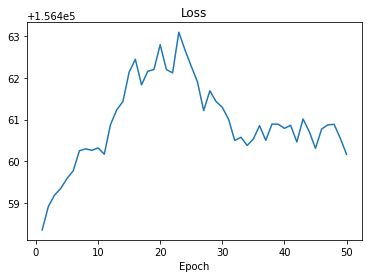

In [61]:
from matplotlib import pyplot as plt
def plot_history(losses):
    fig, ax = plt.subplots()

    epochs = np.arange(1, len(losses) + 1)

    # 損失の推移
    ax.set_title("Loss")
    ax.plot(epochs, losses)
    ax.set_xlabel("Epoch")

    plt.show()
plot_history(losses)

In [62]:
model_path = "../models/LM/"
model_name = "ffn_LM2.pickle"
modelM = DataManager(model_path)
modelM.save_data(model_name, model)

success save : ../models/LM/ffn_LM2.pickle


In [63]:
vocab_name = "vocab1_LM2.pickle"
modelM.save_data(vocab_name, vocab)

success save : ../models/LM/vocab1_LM2.pickle
